In [1]:
import os
import datetime
import tensorflow as tf
from tensorflow.keras.metrics import SparseCategoricalAccuracy, Mean
from tensorflow.keras.utils import Progbar
from tensorflow.keras.datasets import mnist
import uncertainty_wizard as uwiz
import matplotlib.pyplot as plt
from uncertainty_wizard.models.stochastic_utils.layers import UwizBernoulliDropout
from uncertainty_wizard.models import StochasticMode
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from cleverhans.tf2.attacks.fast_gradient_method import fast_gradient_method
from cleverhans.tf2.attacks.projected_gradient_descent import projected_gradient_descent
import seaborn as sns

In [3]:
# Load mnist data 
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Lenght of training samples
print('Lenght of training samples: ', len(x_train))

# Lenght of test samples
print('\nLenght of test samples: ', len(x_test))

# Shape 
print('\nShape: ', x_train[0].shape)
print('\n-----------------------------------------------------------------')

# Preprocess the data
x_train = (x_train.astype('float32') / 255).reshape(x_train.shape[0], 28, 28, 1)
x_test = (x_test.astype('float32') / 255).reshape(x_test.shape[0], 28, 28, 1)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

#x_train, x_test = [np.expand_dims(x.astype('float32') / 255, -1) for x in [x_train, x_test]]
#y_train, y_test = [tf.keras.utils.to_categorical(y, num_classes=10) for y in [y_train, y_test]]


def create_stochastic_model():
    model = uwiz.models.StochasticSequential()
    model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(UwizBernoulliDropout(0.5, stochastic_mode=StochasticMode()))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dense(10, activation='softmax'))

    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                  optimizer=tf.keras.optimizers.legacy.Adadelta(),
                  metrics=['accuracy'])

    return model

Lenght of training samples:  60000

Lenght of test samples:  10000

Shape:  (28, 28)

-----------------------------------------------------------------


In [ ]:
# Re-initialize the model for adversarial training
adv_training_model = create_stochastic_model()

optimizer = tf.keras.optimizers.legacy.Adadelta()
loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
train_loss = Mean(name='train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')

epochs = 50
batch_size = 5000
eps = 0.03
for epoch in range(epochs):
    print(f'Epoch: {epoch + 1}/{epochs}')

    # Initialize the progress bar
    progbar = Progbar(target=len(x_train) // batch_size, unit_name='batch')

    train_loss.reset_state()
    train_accuracy.reset_state()

    for batch_index, (x_batch, y_batch) in enumerate(tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size)):
        with tf.GradientTape() as tape:
            # Generate adversarial examples 
            x_batch_adv = projected_gradient_descent(adv_training_model.inner, x_batch, eps, 0.01, 40, np.inf)

            # Predict on adversarial examples
            adv_pred = adv_training_model.inner(x_batch_adv, training=True)
            loss = loss_object(y_batch, adv_pred)

        # Compute gradients and update model weights
        gradients = tape.gradient(loss, adv_training_model.inner.trainable_variables)
        optimizer.apply_gradients(zip(gradients, adv_training_model.inner.trainable_variables))

        # Update the metrics
        train_loss.update_state(loss)
        train_accuracy.update_state(y_batch, adv_pred)

        # Update the progress bar
        progbar.update(batch_index + 1, values=[("loss", train_loss.result()),
                                                ("accuracy", train_accuracy.result())])

    # Logging the metrics at the end of an epoch
    print(f'Epoch {epoch + 1}, Loss: {train_loss.result().numpy()}, Accuracy: {train_accuracy.result().numpy()}')

os.makedirs(os.path.dirname('data/model/'), exist_ok=True)
adv_training_model.inner.save_weights('data/model/adv_trained_model_weights.h5')
print("\nAdversarial training completed, model weights saved")
        

In [5]:
model = create_stochastic_model()

2024-05-10 10:45:36.181147: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-05-10 10:45:36.181177: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-05-10 10:45:36.181186: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-05-10 10:45:36.181261: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-10 10:45:36.181310: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/uncertainty_wizard/models/stochastic_utils/layers.py:25: UncertaintyWizardWarning: Looks like you are

In [6]:
# Load the saved model weights
model.inner.load_weights('data/model/adv_trained_model_weights.h5')
print("Model weights loaded from disk")

# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
#print('\nTest accuracy', test_acc)
#print('\nTest loss', test_loss)
print(f'\nTest Loss: {test_loss*100:.2f}%, Test Accuracy: {test_acc*100:.2f}%')

# Making predictions on the test set
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate the mean squared error
mse = tf.reduce_mean(tf.square(y_pred - y_test))
print(f'\nMSE: {mse:.3f}')


num_samples = 25
predictions = model.predict(x_test[:num_samples])
predicted_labels = np.argmax(predictions, axis=1)

Model weights loaded from disk


2024-05-10 10:45:37.784259: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


313/313 - 3s - loss: 1.5577 - accuracy: 0.7021 - 3s/epoch - 9ms/step

Test Loss: 155.77%, Test Accuracy: 70.21%
313/313 [==============================] - 1s 3ms/step

MSE: 0.068
1/1 [==============================] - 0s 26ms/step


In [7]:
# Confusion Matrix and Classification Report
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print(confusion_matrix(y_true, y_pred_classes))
print("\n")
print(classification_report(y_true, y_pred_classes))

313/313 [==============================] - 1s 2ms/step
[[ 968    0    2    1    0    0    0    1    8    0]
 [   0 1086   37    4    0    0    4    1    1    2]
 [  88   15  879    0    1    0   14   24    9    2]
 [ 139   11   64  716    0    0    3   48    6   23]
 [  45   18   35    0  502    0    6   41    7  328]
 [ 362   27   37  124    3  168    7   80   43   41]
 [ 288   35   60    0    5    1  558    1    9    1]
 [  14   34   45    0    2    0    1  899    4   29]
 [ 128   41  122   58    3    0    8   91  468   55]
 [  51   12   11   10    8    0    0  135    5  777]]


              precision    recall  f1-score   support

           0       0.46      0.99      0.63       980
           1       0.85      0.96      0.90      1135
           2       0.68      0.85      0.76      1032
           3       0.78      0.71      0.74      1010
           4       0.96      0.51      0.67       982
           5       0.99      0.19      0.32       892
           6       0.93      0.58

In [8]:
"""
Generate adversarial examples batch by batch within a loop then trying to evaluate the model on a single batch of adversarial examples against the entire y_test dataset
"""

if y_test.ndim > 1:
    y_test = np.argmax(y_test, axis=1)

test_accuracy = SparseCategoricalAccuracy()

# Evaluate on clean examples
for x_batch, y_batch in tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(128):
    predictions = model.predict(x_batch)
    test_accuracy.update_state(y_batch, predictions)

accuracy_clean = test_accuracy.result().numpy() * 100
print(f'\nTest accuracy on clean examples: {accuracy_clean:.2f}%')

# Adversarial evaluation settings
eps = 0.3
test_accuracy_fgsm = SparseCategoricalAccuracy()
test_accuracy_pgd = SparseCategoricalAccuracy()

# Evaluate on adversarial examples (FGSM and PGD)
for x_batch, y_batch in tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(128):
    # FGSM examples
    x_adv_fgsm = fast_gradient_method(model.inner, x_batch, eps, np.inf)
    predictions_fgsm = model.predict(x_adv_fgsm)
    test_accuracy_fgsm.update_state(y_batch, predictions_fgsm)


    # PGD examples
    x_adv_pdg = projected_gradient_descent(model.inner, x_batch, eps, 0.01, 40, np.inf)
    predictions_pdg = model.predict(x_adv_pdg)
    test_accuracy_pgd.update_state(y_batch, predictions_pdg)

accuracy_fgsm = test_accuracy_fgsm.result().numpy() * 100
accuracy_pdg = test_accuracy_pgd.result().numpy() * 100


print(f'\nTest accuracy on FGSM adversarial examples: {accuracy_fgsm:.2f}%')
print(f'Test accuracy on PDG adversarial examples: {accuracy_pdg:.2f}%')

accuracies = [accuracy_clean, accuracy_fgsm, accuracy_pdg]

1/1 [==============================] - 0s 11ms/step

Test accuracy on clean examples: 70.21%
1/1 [==============================] - 0s 9ms/step

Test accuracy on FGSM adversarial examples: 34.14%
Test accuracy on PDG adversarial examples: 17.49%


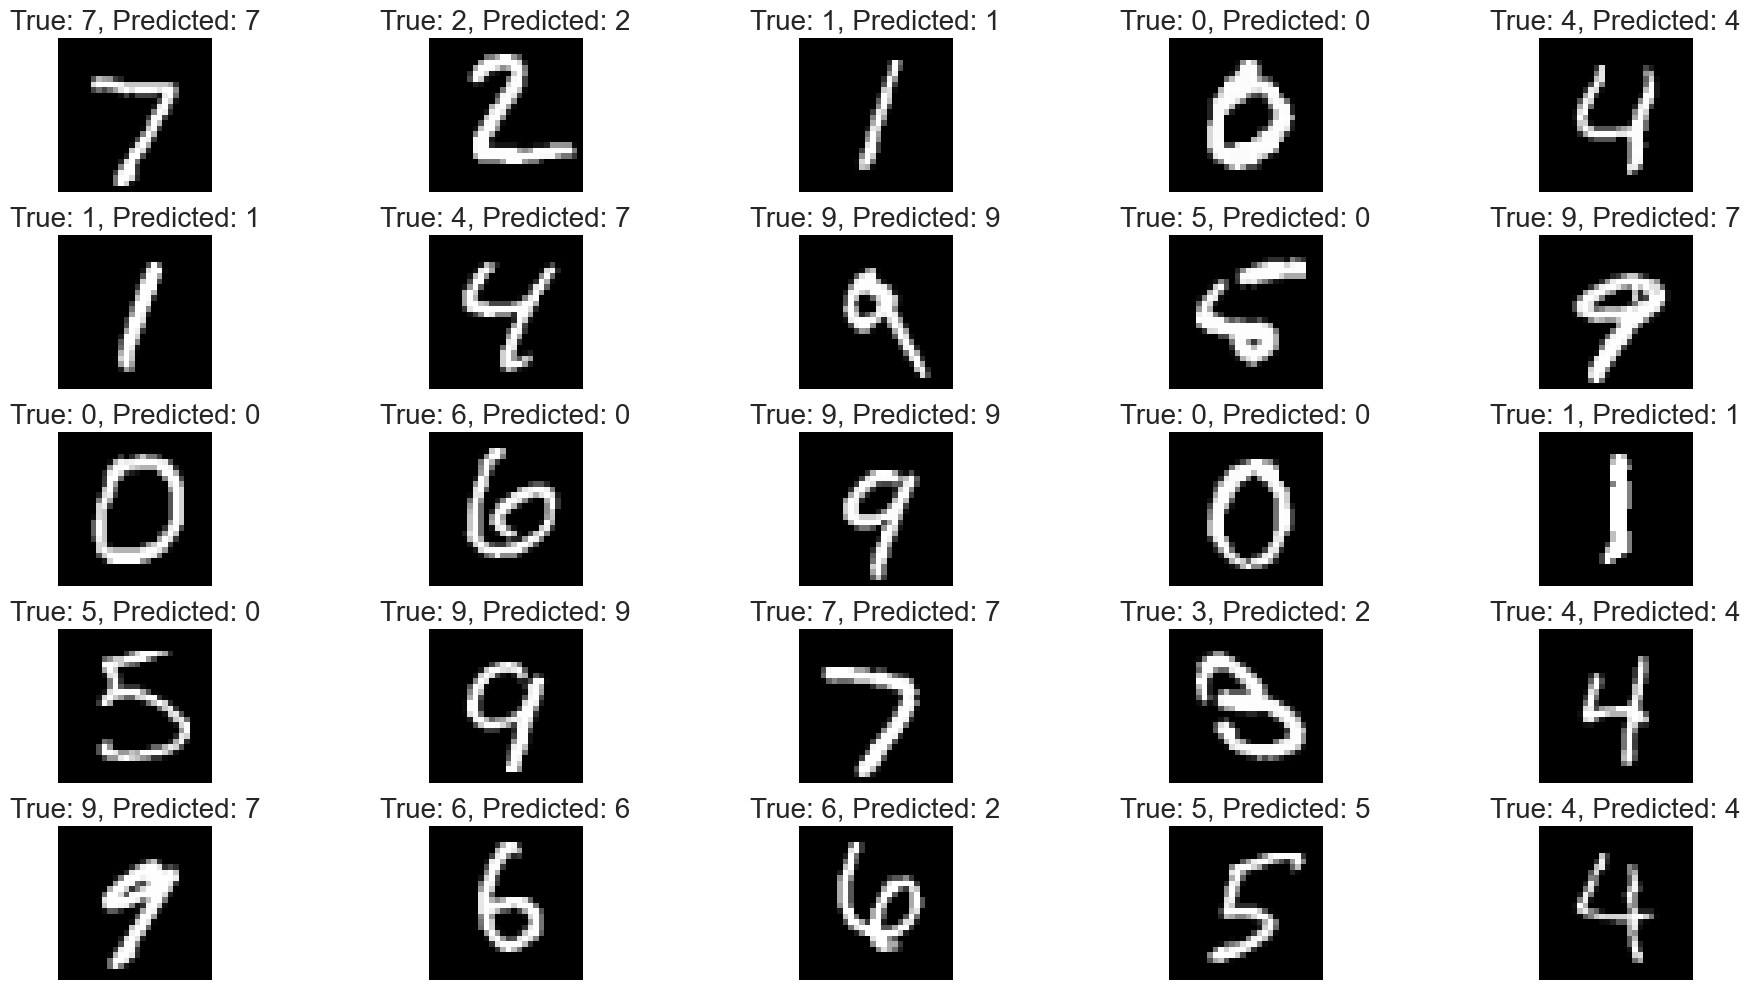

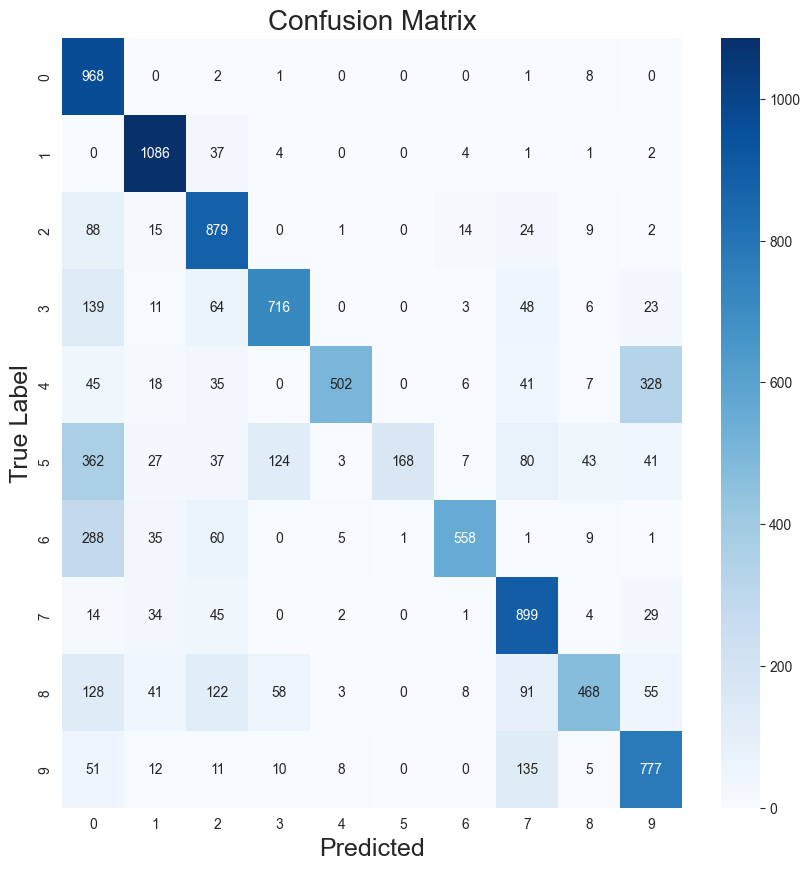

1/1 [==============================] - 0s 11ms/step


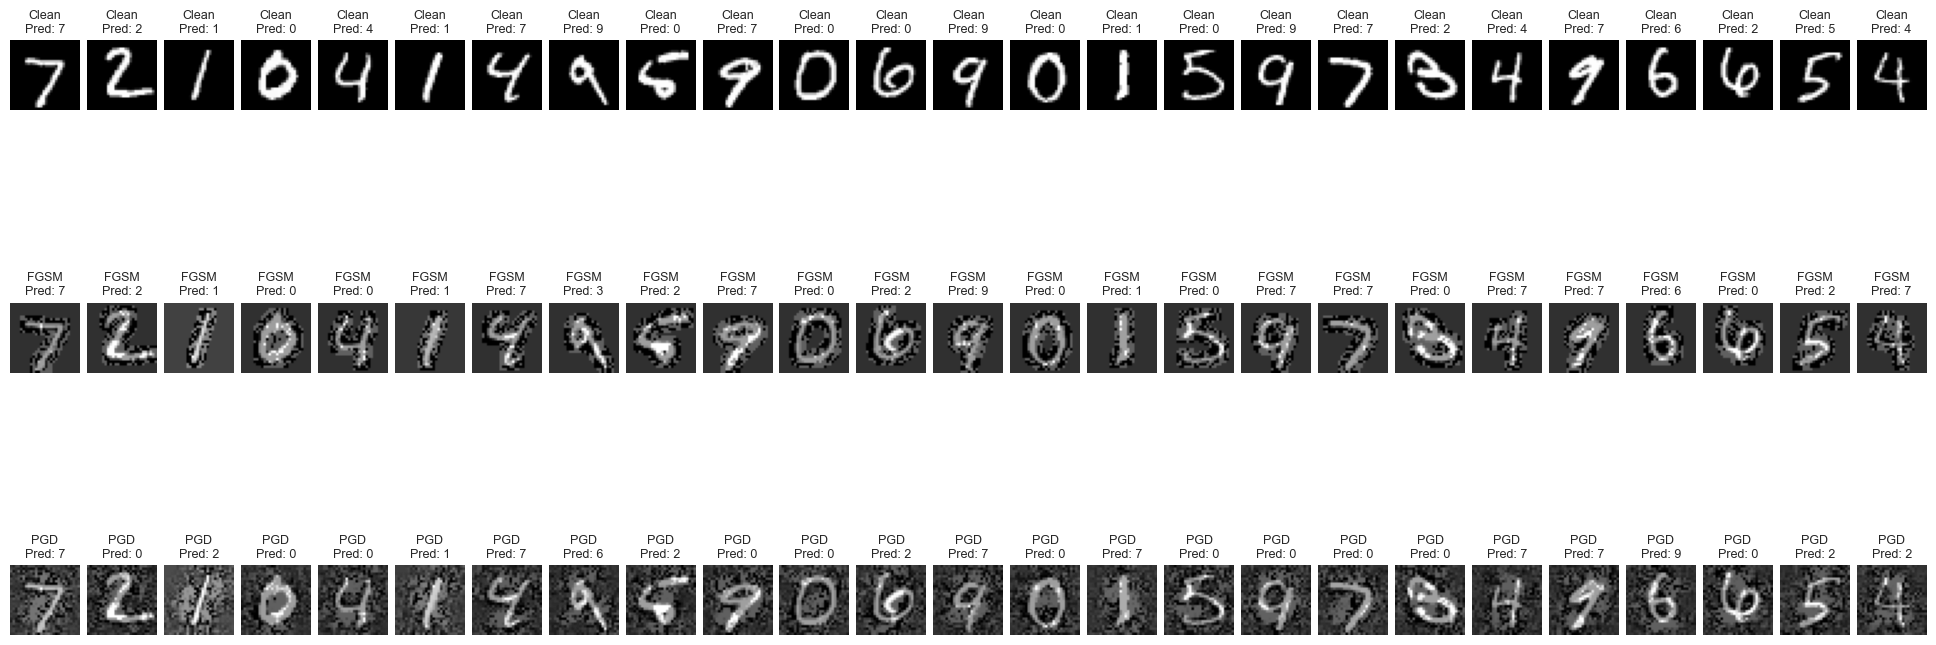

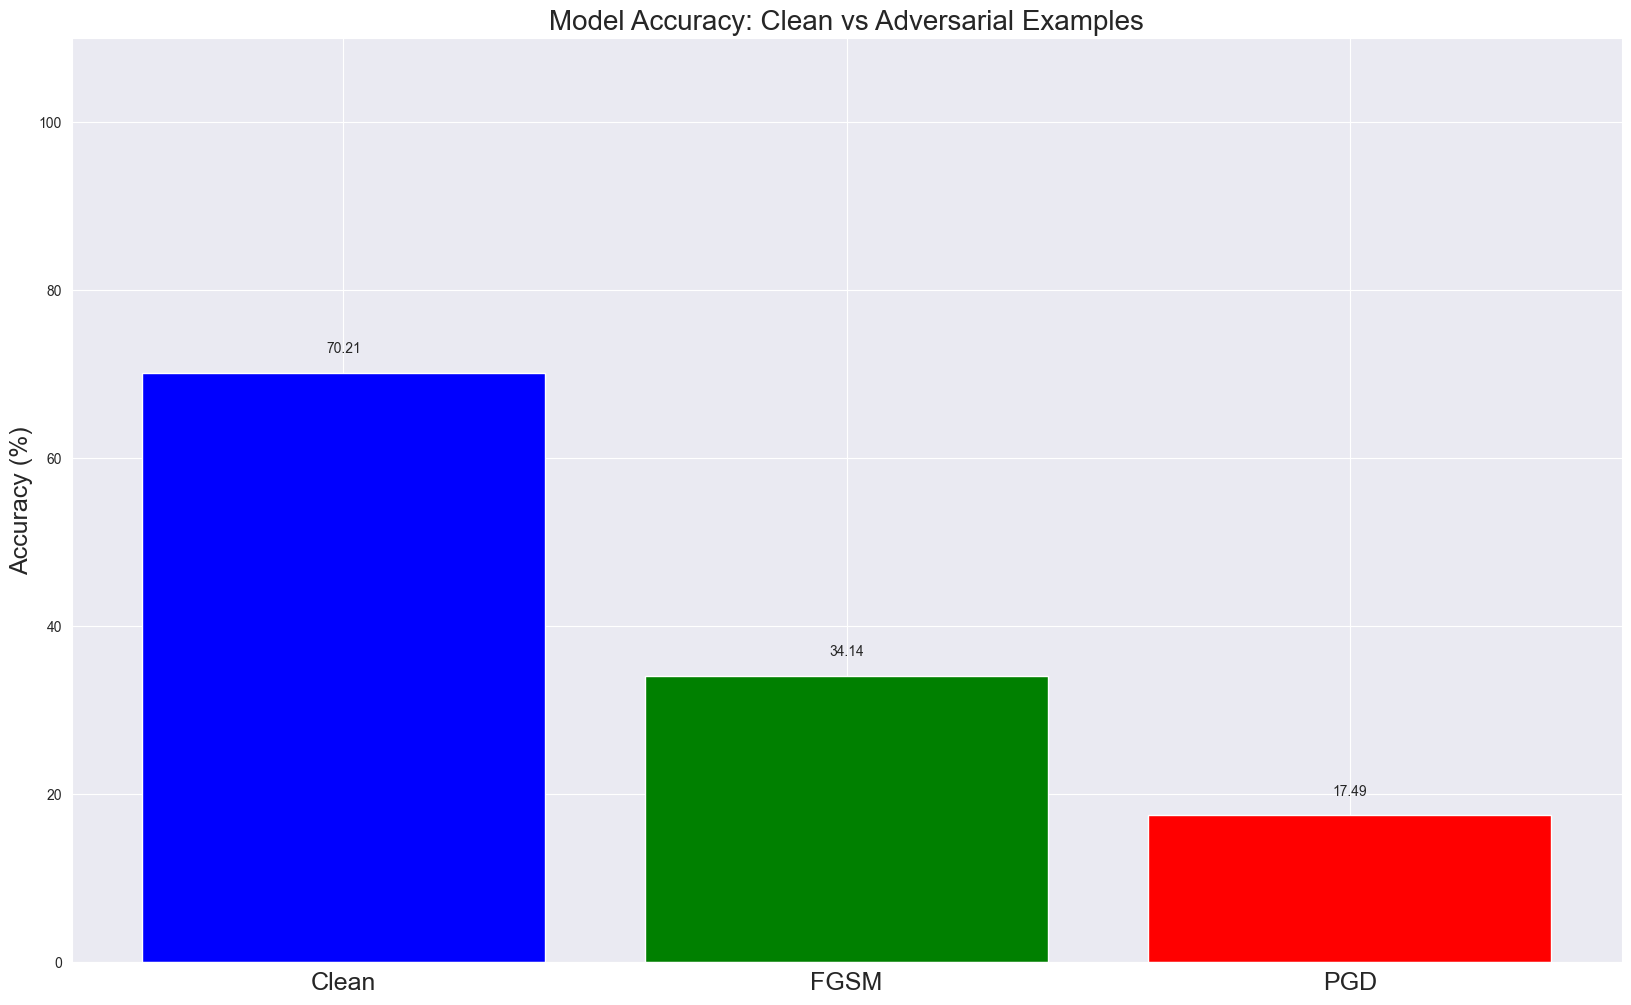

In [9]:
plt.figure(figsize=(20, 10))
for i in range(num_samples):
    plt.subplot(5, 5, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title(f'True: {y_true[i]}, Predicted: {predicted_labels[i]}', fontsize=20)
    plt.axis('off')
plt.tight_layout()
plt.savefig('data/plots/evaluate/predictions.pdf', format='pdf', dpi=300)
plt.show()

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues',
            xticklabels=[str(i) for i in range(10)],
            yticklabels=[str(i) for i in range(10)])
plt.title('Confusion Matrix', fontsize=20)
plt.xlabel('Predicted', fontsize=18)
plt.ylabel('True Label', fontsize=18)
plt.savefig('data/plots/evaluate/cm.pdf', format='pdf', dpi=300)
plt.show()

# Clean and Adversarial examples

#x_adv_fgsm = fast_gradient_method(model.inner, x_test[:num_samples], eps, np.inf)
#predictions_clean = np.argmax(model.predict(x_test[:num_samples]), axis=1)
#predictions_adv = np.argmax(model.predict(x_adv_fgsm), axis=1)

# Generate FGSM adversarial examples
x_adv_fgsm = fast_gradient_method(model.inner, x_test[:num_samples], eps, np.inf)
predictions_fgsm = np.argmax(model.predict(x_adv_fgsm), axis=1)

# Generate PGD adversarial examples
x_adv_pgd = projected_gradient_descent(model.inner, x_test[:num_samples], eps, 0.01, 40, np.inf)
predictions_pgd = np.argmax(model.predict(x_adv_pgd), axis=1)

plt.figure(figsize=(20, 10))
#plt.figure(figsize=(2 * num_samples, 6))

for i in range(num_samples):
    # Plot clean images
    plt.subplot(3, num_samples, i + 1)
    plt.imshow(x_test[i], cmap='gray')  # If x_test is not already in 28x28, reshape is needed
    plt.title(f'Clean\nPred: {np.argmax(model.predict(x_test[i:i+1]), axis=1)[0]}', fontsize=9)
    plt.axis('off')

    # Plot FGSM adversarial images
    plt.subplot(3, num_samples, num_samples + i + 1)
    plt.imshow(x_adv_fgsm[i], cmap='gray')
    plt.title(f'FGSM\nPred: {predictions_fgsm[i]}', fontsize=9)
    plt.axis('off')

    # Plot PGD adversarial images
    plt.subplot(3, num_samples, 2 * num_samples + i + 1)
    plt.imshow(x_adv_pgd[i], cmap='gray')
    plt.title(f'PGD\nPred: {predictions_pgd[i]}', fontsize=9)
    plt.axis('off')
plt.tight_layout(pad=3, w_pad=0.5, h_pad=1.0)

timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
filename = f'pred_clean_vs_adv_{timestamp}.png'
plot_dir = './data/plots//evaluate'
os.makedirs(plot_dir, exist_ok=True)
plt.savefig(os.path.join(plot_dir, filename))

plt.show()


# Compare
plt.figure(figsize=(20, 12))
bar_positions = np.arange(len(accuracies))
plt.bar(bar_positions, accuracies, color=['blue', 'green', 'red'])
plt.xticks(bar_positions, labels=['Clean', 'FGSM', 'PGD'], fontsize=18)
plt.ylabel('Accuracy (%)', fontsize=18)
plt.title('Model Accuracy: Clean vs Adversarial Examples', fontsize=20)
plt.ylim(0, 110)

for i, acc in enumerate(accuracies):
    plt.text(i, acc + 2, f'{acc:.2f}', ha='center', va='bottom')

plt.savefig('data/plots/evaluate/bar_adversarial_clean.pdf', format='pdf', dpi=300)
plt.show()

1/1 [==============================] - 0s 10ms/step


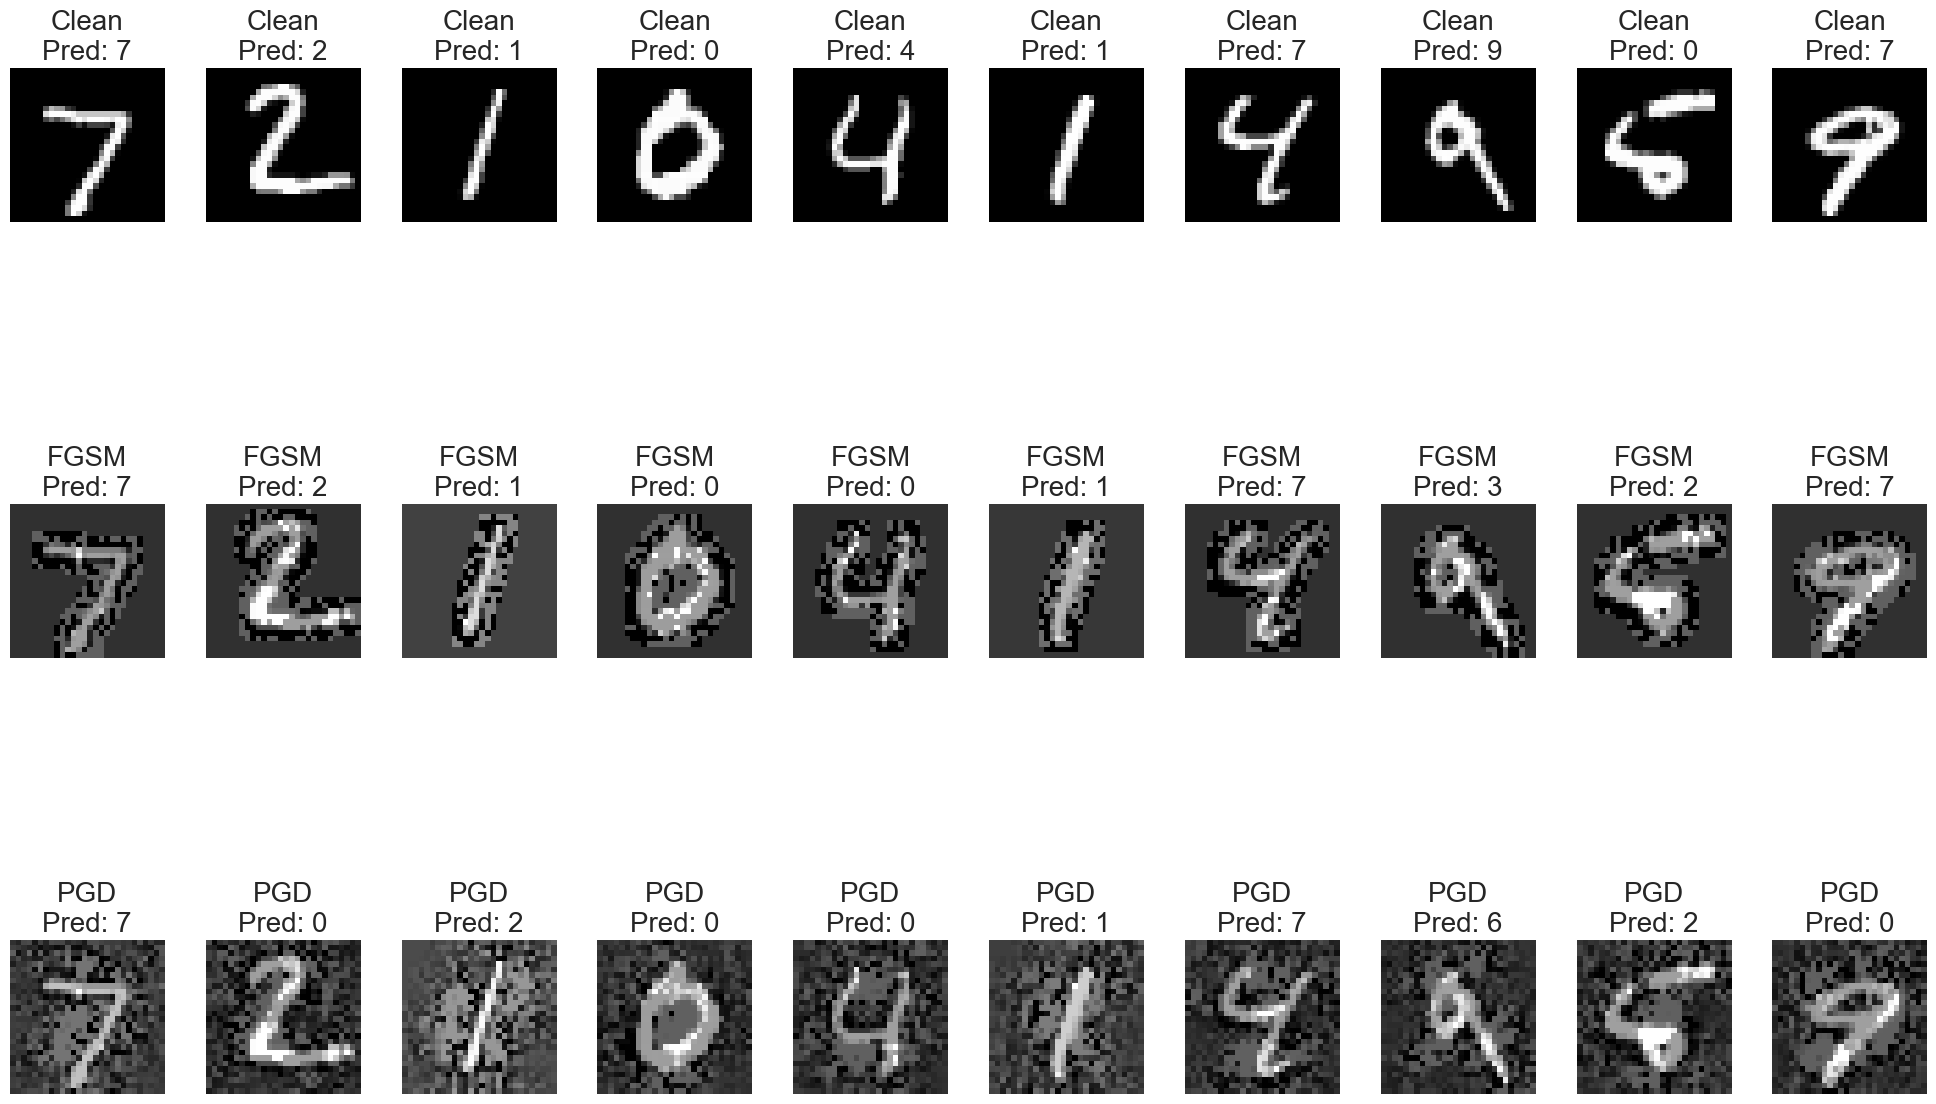

In [10]:
fig, axs = plt.subplots(3, 10, figsize=(20, 15))

for i in range(10):
    # Plot clean images
    axs[0, i].imshow(x_test[i], cmap='gray')
    axs[0, i].set_title(f'Clean\nPred: {np.argmax(model.predict(x_test[i:i+1]), axis=1)[0]}', fontsize=20)
    axs[0, i].axis('off')

    # Plot FGSM adversarial images
    axs[1, i].imshow(x_adv_fgsm[i], cmap='gray')
    axs[1, i].set_title(f'FGSM\nPred: {predictions_fgsm[i]}', fontsize=20)
    axs[1, i].axis('off')

    # Plot PGD adversarial images
    axs[2, i].imshow(x_adv_pgd[i], cmap='gray')
    axs[2, i].set_title(f'PGD\nPred: {predictions_pgd[i]}', fontsize=20)
    axs[2, i].axis('off')

plt.savefig('data/plots/evaluate/clean_vs_adversarial_inputs.pdf', format='pdf', dpi=300)
plt.tight_layout(pad=3.0) 

Model weights loaded from data/model/clean_model_weights.h5
1/1 [==============================] - 0s 11ms/step
Model weights loaded from data/model/adv_trained_model_weights.h5
1/1 [==============================] - 0s 11ms/step


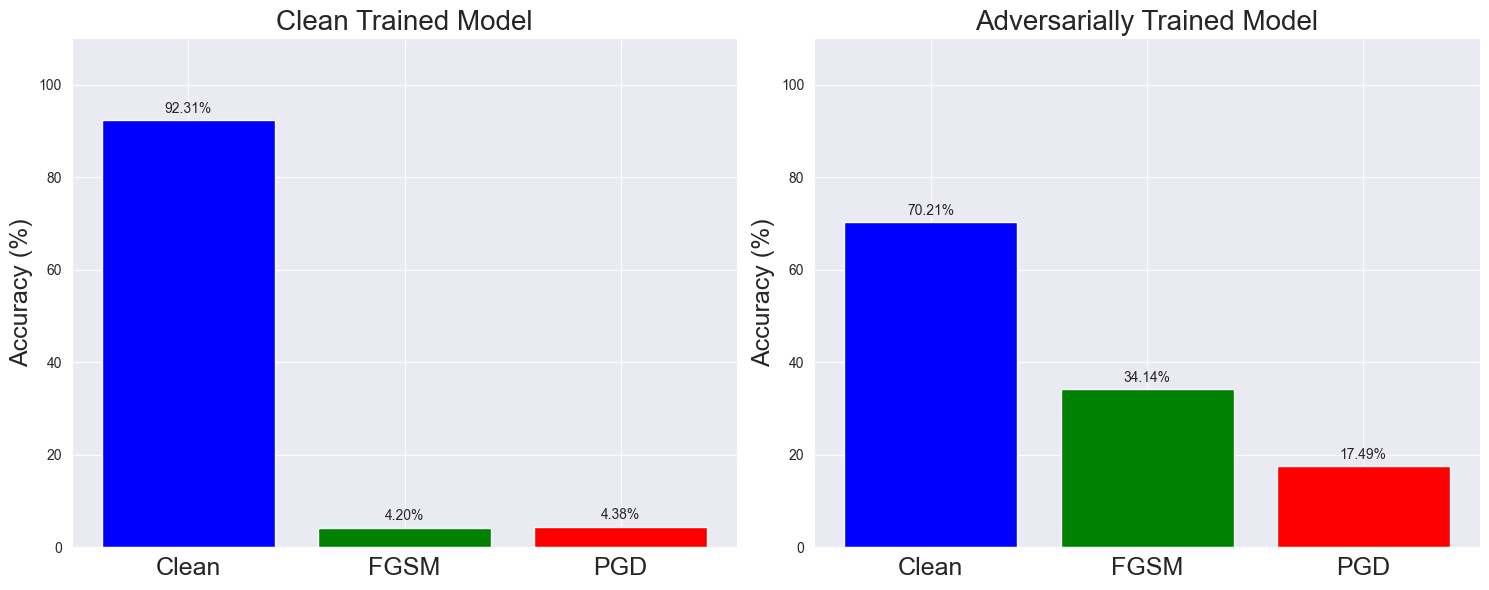

In [11]:
# Define model weights for evaluation
model_weights = {
    'Clean Trained': 'data/model/clean_model_weights.h5',
    'Adversarially Trained': 'data/model/adv_trained_model_weights.h5'
}

# Prepare figure for subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 6))  # 1 row, 2 columns

for idx, (label, weight_path) in enumerate(model_weights.items()):
    # Load the saved model weights
    model.inner.load_weights(weight_path)  # Adjust this if model loading differs
    print(f"Model weights loaded from {weight_path}")

    if y_test.ndim > 1:
        y_test = np.argmax(y_test, axis=1)  # Ensure y_test is in sparse format

    test_accuracy = SparseCategoricalAccuracy()
    test_accuracy_fgsm = SparseCategoricalAccuracy()
    test_accuracy_pgd = SparseCategoricalAccuracy()

    eps = 0.3
    accuracies = []

    # Evaluate on clean examples
    for x_batch, y_batch in tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(128):
        predictions = model.inner.predict(x_batch)
        test_accuracy.update_state(y_batch, predictions)

    # FGSM and PGD evaluations
    for x_batch, y_batch in tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(128):
        x_adv_fgsm = fast_gradient_method(model.inner, x_batch, eps, np.inf)
        predictions_fgsm = model.inner.predict(x_adv_fgsm)
        test_accuracy_fgsm.update_state(y_batch, predictions_fgsm)

        x_adv_pgd = projected_gradient_descent(model.inner, x_batch, eps, 0.01, 40, np.inf)
        predictions_pgd = model.inner.predict(x_adv_pgd)
        test_accuracy_pgd.update_state(y_batch, predictions_pgd)

    accuracies.extend([
        test_accuracy.result().numpy() * 100,
        test_accuracy_fgsm.result().numpy() * 100,
        test_accuracy_pgd.result().numpy() * 100
    ])

    # Plotting results
    bar_positions = np.arange(len(accuracies))
    bars = axs[idx].bar(bar_positions, accuracies, color=['blue', 'green', 'red'])
    axs[idx].set_xticks(bar_positions)
    axs[idx].set_xticklabels(['Clean', 'FGSM', 'PGD'], fontsize=18)
    axs[idx].set_title(f'{label} Model', fontsize=20)
    axs[idx].set_ylabel('Accuracy (%)', fontsize=18)
    axs[idx].set_ylim(0, 110)

    for bar in bars:
        yval = bar.get_height()
        axs[idx].text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval:.2f}%', ha='center', va='bottom', fontsize=10)


plt.tight_layout()
plt.savefig('data/plots/evaluate/compare_models.pdf', format='pdf', dpi=300)
plt.show()